In [1]:
from rdkit import Chem
import tensorflow as tf
from fia_gnn_preprocessing import FiaGnnPreprocessor, get_nfp_preprocessor, get_output_signature, get_padding_values

# Deactivate RDkit messages
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

# 1) Load models

In [2]:
# Load tf models:
path_to_fia_gas_model = 'fia_gnn_model_gas'
path_to_fia_solv_model = 'fia_gnn_model_solv'
fia_gas_model = tf.keras.models.load_model(path_to_fia_gas_model, compile=False)
fia_solv_model = tf.keras.models.load_model(path_to_fia_solv_model, compile=False)

# Load nfp preprocessors:
path_to_fia_gas_preprocessor_json = r'fia_gnn_model_gas\preprocessor_fia_gas.json'
path_to_fia_solv_preprocessor_json = r'fia_gnn_model_solv\preprocessor_fia_solv.json'
fia_gas_preprocessor = get_nfp_preprocessor(path_to_fia_gas_preprocessor_json)
fia_solv_preprocessor = get_nfp_preprocessor(path_to_fia_solv_preprocessor_json)

# Generate tf output signature and padding values:
# Output signature and padding values of fia_gas and fia_solv preprocessor are equal,
# they are generated once for both models: 
output_signature = get_output_signature(fia_gas_preprocessor)
padding_values = get_padding_values(fia_gas_preprocessor)


# 2) Example molecules

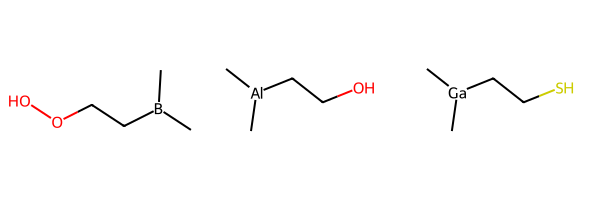

In [3]:
smiles_list = ['CB(C)CCOO', 'C[Al](C)CCO', 'C[Ga](C)CCS']
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(smiles) for smiles in smiles_list])

# 3) Predict example molecules

In [4]:
# Generate FiaGnnPreprocessor object for each molecule:
preprocessor_list = []
for smiles in smiles_list:
    mol = Chem.MolFromSmiles(smiles)
    preprocessor_list.append(FiaGnnPreprocessor(mol, fia_gas_preprocessor, fia_solv_preprocessor))

In [5]:
# Generate tf data set and predict fia_gas
tf_dataset_fia_gas = (
    tf.data.Dataset.from_generator(
        lambda: (preprocessor.fia_gas_input for preprocessor in preprocessor_list),
        output_signature=output_signature,
    )
    .padded_batch(batch_size=len(preprocessor_list), padding_values=padding_values)
    )
fia_gas_prediction = fia_gas_model.predict(tf_dataset_fia_gas)
print('fia_gas values [kJ/mol]:')
print(fia_gas_prediction)

1/1 [==============================] - 3s 3s/step
fia_gas values [kJ/mol]:
[[265.97656]
 [395.8507 ]
 [308.1448 ]]


In [6]:
# Generate tf data set and predict fia_solv
tf_dataset_fia_solv = (
    tf.data.Dataset.from_generator(
        lambda: (preprocessor.fia_solv_input for preprocessor in preprocessor_list),
        output_signature=output_signature,
    )
    .padded_batch(batch_size=len(preprocessor_list), padding_values=padding_values)
    )
fia_solv_prediction = fia_solv_model.predict(tf_dataset_fia_solv)
print('fia_solv values [kJ/mol]:')
print(fia_solv_prediction)

1/1 [==============================] - 2s 2s/step
fia_solv values [kJ/mol]:
[[135.02184]
 [223.83458]
 [152.77138]]


# 4) Check for unknown tokens:
If unknown atom or bond tokens are passed to the model, predictions can be innacurate

In [7]:
for preprocessor in preprocessor_list:
    print(preprocessor.unknown_atom_token)
print('-> No unknown atom tokens')

False
False
False
-> No unknown atom tokens


In [8]:
for preprocessor in preprocessor_list:
    print(preprocessor.unknown_bond_token)
print('-> At least one unknown bond token in first molecule')
print('-> Model does not recognize peroxide bonds (O-O)')

True
False
False
-> At least one unknown bond token in first molecule
-> Model does not recognize peroxide bonds (O-O)
